In [1]:
import pickle as pkl
from simulator.rl_wrapper import CentralizedAggregatedSim
from simulator.fast_simulator import FastSimulator
import matplotlib
import matplotlib.pyplot as plt
import torch
from simulator.rl import RL, ActionSpace
import pandas as pd
import numpy as np
import seaborn as sns

action_space = ActionSpace()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
path_folder = "saved_models"

In [2]:
fsim = FastSimulator(interval=30)
df = fsim.rsts[0]

In [3]:
mall_layout = {
    "Happy’s Department Store": (100, 50, 200, 200),
    "Weekend Outdoors": (900, 50, 200, 200),
    "Elegant Styles": (100, 550, 150, 150),
    "Urban Gear": (260, 550, 150, 150),  # Updated position
    "Tech Haven": (400, 100, 100, 100),
    "Gamer’s Paradise": (700, 100, 100, 100),
    "Savor’s Grille": (400, 250, 150, 150),
    "Café Fresco": (600, 250, 150, 150),
    "Quick Bites Food Court": (800, 350, 200, 100),
    "Serene Spa and Salon": (250, 400, 150, 150),
    "Vital Pharmacy": (600, 450, 150, 150),
    "Book Nook": (100, 700, 100, 100),  # Updated position
    "Happy Florist": (500, 600, 100, 100),
    "Gifts & More": (500, 600, 100, 100),
    "Cineplex": (650, 600, 200, 150),  # Updated size
    "Child’s Play": (900, 650, 150, 150),  # Updated position and size
    "Powerhouse Gym": (50, 250, 150, 150),
    "Information Desk": (1000, 350, 100, 100),
    "Restrooms and Baby Care Rooms": (1000, 500, 100, 100),
    "Weekend Live"  : (900, 50, 200, 100),
    "Holiday Celebrations": (900, 50, 200, 100),
}

store_areas = {}
for key, val in mall_layout.items():
    store_areas[key] = val[2] * val[3]
    
ROOM_HEIGHT = 3
DENSITY = 1.225
c_p = 1005
AMBIENT_TEMP = 25

#df['reward'] = df['normalized_votes'] * 18 * (-down -up + 3 * no_change) + 1/100 * power

In [9]:
store_areas

{'Happy’s Department Store': 40000,
 'Weekend Outdoors': 40000,
 'Elegant Styles': 22500,
 'Urban Gear': 22500,
 'Tech Haven': 10000,
 'Gamer’s Paradise': 10000,
 'Savor’s Grille': 22500,
 'Café Fresco': 22500,
 'Quick Bites Food Court': 20000,
 'Serene Spa and Salon': 22500,
 'Vital Pharmacy': 22500,
 'Book Nook': 10000,
 'Happy Florist': 10000,
 'Gifts & More': 10000,
 'Cineplex': 30000,
 'Child’s Play': 22500,
 'Powerhouse Gym': 22500,
 'Information Desk': 10000,
 'Restrooms and Baby Care Rooms': 10000,
 'Weekend Live': 20000,
 'Holiday Celebrations': 20000}

In [10]:
total = 0
for k, v in store_areas.items():
    total+=v

In [4]:
# total population change over time

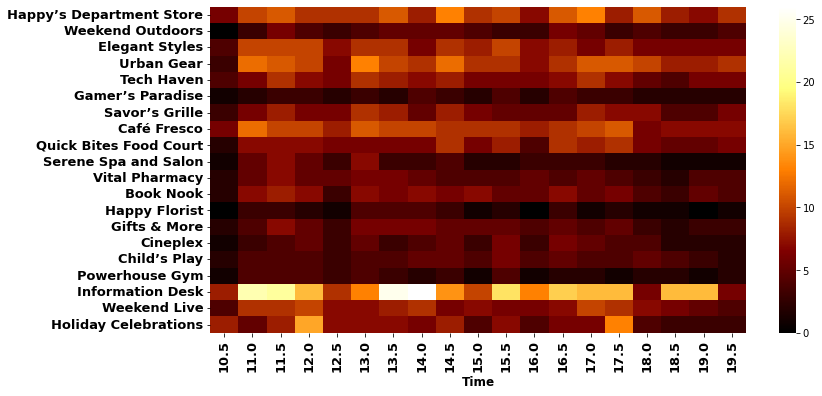

In [5]:
fsim = FastSimulator(interval=30)
pops = []
time = 10
for df in fsim.rsts:
    time += 0.5
    pops.append(df.set_index('Store').iloc[:,:-2].sum(axis=1).to_dict() | {'time': time})
store_pops_df = pd.DataFrame(pops).set_index('time')

plt.figure(figsize=(12, 6))
sns.heatmap(store_pops_df.iloc[:-1, :].T, annot=False, cmap="afmhot", fmt=".0f")
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold', rotation=90)
plt.show()

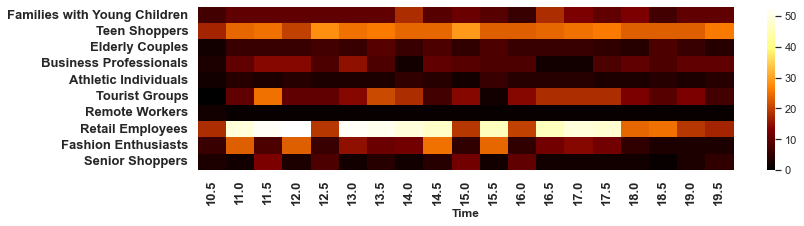

In [6]:
rl_model = pkl.load(open(f"{path_folder}/centralized_control_model.pkl", "rb"))
sim = CentralizedAggregatedSim(FastSimulator(interval=30))
sim.step()
temp_contorls = []
recorded_states = []
actions = []
for i in range(19):
    state = sim.get_states()
    recorded_states.append(state)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    action = rl_model.predict(state)
    rl_temp = action_space.convert(action.item())
    actions.append(rl_temp)
    temp_contorls.append(rl_temp)
    sim.apply_action(rl_temp)
    sim.step()

recorded_states = np.array(recorded_states)
recorded_pops, times = recorded_states[:, :-2].T, recorded_states[:, -1]
df = pd.DataFrame(recorded_pops, columns=times)
pop_types = sim.rst_df.columns.tolist()[1:-2]
df.index = pop_types

sns.set(rc={'figure.figsize':(12, 3)})
sns.heatmap(df, annot=False, cmap="afmhot", fmt=".0f")
plt.xlabel('Time', fontsize=12, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.xticks(fontsize=13, fontweight='bold', rotation=90)
plt.show()
